In [ ]:
# ======================================================
# EduGen - Text-to-Image Diffusion Model for STEM Illustration Generation
# Dataset: ScienceQA (text → diagram/illustration)
# ======================================================

# !pip install datasets==2.18.0 torchvision evaluate torchmetrics sentence-transformers matplotlib tqdm scikit-image -q
!pip install datasets==2.18.0 torchvision evaluate pytorch-fid torchmetrics sentence-transformers matplotlib tqdm scikit-image -q torch-fidelity

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from PIL import Image
import random, os, math
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from sentence_transformers import SentenceTransformer, util
from torchmetrics.image.fid import FrechetInceptionDistance
import nltk
nltk.download('punkt')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 13.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 7.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━

2025-11-13 08:32:13.747479: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763022733.920517      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763022733.966978      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:

# ---------------------------
# Config
# ---------------------------
MODE = "full"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE = 128
BATCH_SIZE = 16 if MODE=="full" else 4
EPOCHS = 100 if MODE=="full" else 2
LR = 1e-4
DATA_FRAC = 0.1 if MODE=="demo" else 1.0
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
print(DEVICE)

# ---------------------------
# Load dataset
# ---------------------------
print("Loading ScienceQA dataset...")
ds = load_dataset("derek-thomas/ScienceQA")
train_ds, val_ds, test_ds = ds["train"], ds["validation"], ds["test"]

def preprocess_sample(ex):
    text = (ex.get("lecture","") or "") + " " + (ex.get("hint","") or "") + " " + (ex.get("question","") or "")
    return {"text": text.strip(), "image": ex.get("image", None)}

train = [preprocess_sample(x) for x in train_ds]
val = [preprocess_sample(x) for x in val_ds]

if MODE=="demo":
    train = train[:int(len(train)*DATA_FRAC)]
    val = val[:500]

print(f"Train={len(train)}, Val={len(val)}")


cuda
Loading ScienceQA dataset...


Generating train split:   0%|          | 0/12726 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4241 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4241 [00:00<?, ? examples/s]

Train=12726, Val=4241


In [ ]:

# ---------------------------
# Preprocessing / Transforms
# ---------------------------
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

class ScienceQADiffusion(Dataset):
    def __init__(self, data, transform):
        self.data = [d for d in data if d["image"] is not None]
        self.transform = transform
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        d = self.data[idx]
        img = d["image"].convert("RGB")
        img = self.transform(img)
        text = d["text"]
        return img, text

train_loader = DataLoader(ScienceQADiffusion(train, transform), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(ScienceQADiffusion(val, transform), batch_size=BATCH_SIZE, shuffle=False)

# ---------------------------
# Pre-trained text encoder
# ---------------------------
sbert = SentenceTransformer('all-MiniLM-L6-v2', device=DEVICE)
TEXT_EMB_DIM = 384

def encode_texts(texts):
    return torch.tensor(sbert.encode(texts, convert_to_tensor=True, device=DEVICE), device=DEVICE)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:

# ---------------------------
# UNet-like model for Diffusion (Deeper & Wider)
# ---------------------------
class Block(nn.Module):
    def __init__(self, in_c, out_c, time_emb_dim, text_emb_dim):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_c)
        self.text_mlp = nn.Linear(text_emb_dim, out_c)
        self.conv1 = nn.Conv2d(in_c, out_c, 3, 1, 1)
        self.conv2 = nn.Conv2d(out_c, out_c, 3, 1, 1)
        self.norm1 = nn.GroupNorm(8, out_c)
        self.norm2 = nn.GroupNorm(8, out_c)
        self.act = nn.SiLU()
        self.res_conv = nn.Conv2d(in_c, out_c, 1) if in_c != out_c else nn.Identity()

    def forward(self, x, t_emb, txt_emb):
        h = self.conv1(x)
        h += self.time_mlp(t_emb)[:, :, None, None]
        h += self.text_mlp(txt_emb)[:, :, None, None]
        h = self.norm1(h)
        h = self.act(h)
        h = self.conv2(h)
        h = self.norm2(h)
        return h + self.res_conv(x)

class SimpleUNet(nn.Module):
    def __init__(self, img_ch=3, base_c=128, time_emb_dim=128, text_emb_dim=TEXT_EMB_DIM):
        super().__init__()
        self.time_mlp = nn.Sequential(nn.Linear(1, time_emb_dim), nn.SiLU())
        self.text_emb_proj = nn.Linear(text_emb_dim, text_emb_dim)
        self.block1 = Block(img_ch, base_c, time_emb_dim, text_emb_dim)
        self.block2 = Block(base_c, base_c*2, time_emb_dim, text_emb_dim)
        self.block3 = Block(base_c*2, base_c*2, time_emb_dim, text_emb_dim)
        self.block4 = Block(base_c*2, base_c, time_emb_dim, text_emb_dim)
        self.final = nn.Conv2d(base_c, img_ch, 1)
    def forward(self, x, t, txt_emb):
        t_emb = self.time_mlp(t.unsqueeze(1))
        txt_emb = self.text_emb_proj(txt_emb)
        h = self.block1(x, t_emb, txt_emb)
        h = self.block2(h, t_emb, txt_emb)
        h = self.block3(h, t_emb, txt_emb)
        h = self.block4(h, t_emb, txt_emb)
        out = self.final(h)
        return out

# ---------------------------
# Diffusion helper functions
# ---------------------------
def noise_schedule(timesteps):
    betas = torch.linspace(1e-4, 0.02, timesteps)
    alphas = 1 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    return betas, alphas, alphas_cumprod

T = 300
betas, alphas, alphas_cumprod = noise_schedule(T)
betas, alphas, alphas_cumprod = betas.to(DEVICE), alphas.to(DEVICE), alphas_cumprod.to(DEVICE)

def forward_diffusion(x0, t):
    noise = torch.randn_like(x0)
    sqrt_alpha = torch.sqrt(alphas_cumprod[t])[:,None,None,None]
    sqrt_one_minus = torch.sqrt(1 - alphas_cumprod[t])[:,None,None,None]
    return sqrt_alpha * x0 + sqrt_one_minus * noise, noise

def sample_t(batch_size, T):
    return torch.randint(0, T, (batch_size,), device=DEVICE)

# ---------------------------
# Initialize model
# ---------------------------
unet = SimpleUNet(img_ch=3).to(DEVICE)
optimizer = optim.Adam(unet.parameters(), lr=LR)
criterion = nn.MSELoss()


In [ ]:

# ---------------------------
# Training loop
# ---------------------------
def train_epoch():
    unet.train()
    total = 0
    for imgs, texts in tqdm(train_loader, desc="Train"):
        imgs = imgs.to(DEVICE)
        txt_emb = encode_texts(texts)
        t = sample_t(imgs.size(0), T)
        x_t, noise = forward_diffusion(imgs, t)
        pred_noise = unet(x_t, t.float()/T, txt_emb)
        loss = criterion(pred_noise, noise)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        total += loss.item()
    return total/len(train_loader)

def evaluate_model():
    unet.eval()
    total = 0
    with torch.no_grad():
        for imgs, texts in tqdm(val_loader, desc="Val"):
            imgs = imgs.to(DEVICE)
            txt_emb = encode_texts(texts)
            t = sample_t(imgs.size(0), T)
            x_t, noise = forward_diffusion(imgs, t)
            pred_noise = unet(x_t, t.float()/T, txt_emb)
            total += criterion(pred_noise, noise).item()
    return total/len(val_loader)

for ep in range(1, EPOCHS+1):
    tr = train_epoch()
    vl = evaluate_model()
    print(f"Epoch {ep}/{EPOCHS} | Train Loss={tr:.4f} | Val Loss={vl:.4f}")

torch.save(unet.state_dict(), "diffusion_stem_v2.pt")


Train:   0%|          | 0/389 [00:00<?, ?it/s]/tmp/ipykernel_48/3036464093.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sbert.encode(texts, convert_to_tensor=True, device=DEVICE), device=DEVICE)
Val: 100%|██████████| 132/132 [00:21<00:00,  6.20it/s]


Epoch 1/100 | Train Loss=0.1340 | Val Loss=0.0761


Val: 100%|██████████| 132/132 [00:21<00:00,  6.18it/s]


Epoch 2/100 | Train Loss=0.0694 | Val Loss=0.0702


Val: 100%|██████████| 132/132 [00:21<00:00,  6.20it/s]


Epoch 3/100 | Train Loss=0.0597 | Val Loss=0.0544


Val: 100%|██████████| 132/132 [00:21<00:00,  6.24it/s]


Epoch 4/100 | Train Loss=0.0552 | Val Loss=0.0537


Val: 100%|██████████| 132/132 [00:21<00:00,  6.23it/s]


Epoch 5/100 | Train Loss=0.0503 | Val Loss=0.0481


Val: 100%|██████████| 132/132 [00:21<00:00,  6.22it/s]


Epoch 6/100 | Train Loss=0.0450 | Val Loss=0.0435


Val: 100%|██████████| 132/132 [00:21<00:00,  6.21it/s]


Epoch 7/100 | Train Loss=0.0434 | Val Loss=0.0430


Val: 100%|██████████| 132/132 [00:21<00:00,  6.22it/s]


Epoch 8/100 | Train Loss=0.0415 | Val Loss=0.0377


Val: 100%|██████████| 132/132 [00:21<00:00,  6.20it/s]


Epoch 9/100 | Train Loss=0.0392 | Val Loss=0.0389


Val: 100%|██████████| 132/132 [00:21<00:00,  6.22it/s]


Epoch 10/100 | Train Loss=0.0386 | Val Loss=0.0381


Val: 100%|██████████| 132/132 [00:21<00:00,  6.22it/s]


Epoch 11/100 | Train Loss=0.0396 | Val Loss=0.0365


Val: 100%|██████████| 132/132 [00:21<00:00,  6.22it/s]


Epoch 12/100 | Train Loss=0.0365 | Val Loss=0.0329


Val: 100%|██████████| 132/132 [00:21<00:00,  6.21it/s]


Epoch 13/100 | Train Loss=0.0366 | Val Loss=0.0345


Val: 100%|██████████| 132/132 [00:21<00:00,  6.23it/s]


Epoch 14/100 | Train Loss=0.0358 | Val Loss=0.0344


Val: 100%|██████████| 132/132 [00:21<00:00,  6.20it/s]


Epoch 15/100 | Train Loss=0.0349 | Val Loss=0.0350


Val: 100%|██████████| 132/132 [00:21<00:00,  6.23it/s]


Epoch 16/100 | Train Loss=0.0327 | Val Loss=0.0331


Val: 100%|██████████| 132/132 [00:21<00:00,  6.23it/s]


Epoch 17/100 | Train Loss=0.0327 | Val Loss=0.0333


Val: 100%|██████████| 132/132 [00:21<00:00,  6.21it/s]


Epoch 18/100 | Train Loss=0.0315 | Val Loss=0.0307


Val: 100%|██████████| 132/132 [00:21<00:00,  6.21it/s]


Epoch 19/100 | Train Loss=0.0312 | Val Loss=0.0308


Val: 100%|██████████| 132/132 [00:21<00:00,  6.23it/s]


Epoch 20/100 | Train Loss=0.0315 | Val Loss=0.0322


Val: 100%|██████████| 132/132 [00:21<00:00,  6.22it/s]


Epoch 21/100 | Train Loss=0.0317 | Val Loss=0.0322


Val: 100%|██████████| 132/132 [00:21<00:00,  6.23it/s]


Epoch 22/100 | Train Loss=0.0307 | Val Loss=0.0305


Val: 100%|██████████| 132/132 [00:21<00:00,  6.23it/s]


Epoch 23/100 | Train Loss=0.0312 | Val Loss=0.0318


Val: 100%|██████████| 132/132 [00:21<00:00,  6.23it/s]


Epoch 24/100 | Train Loss=0.0306 | Val Loss=0.0289


Val: 100%|██████████| 132/132 [00:21<00:00,  6.20it/s]


Epoch 25/100 | Train Loss=0.0298 | Val Loss=0.0289


Val: 100%|██████████| 132/132 [00:21<00:00,  6.22it/s]


Epoch 26/100 | Train Loss=0.0304 | Val Loss=0.0309


Val: 100%|██████████| 132/132 [00:21<00:00,  6.20it/s]


Epoch 27/100 | Train Loss=0.0293 | Val Loss=0.0284


Val: 100%|██████████| 132/132 [00:21<00:00,  6.21it/s]


Epoch 28/100 | Train Loss=0.0289 | Val Loss=0.0318


Val: 100%|██████████| 132/132 [00:21<00:00,  6.21it/s]


Epoch 29/100 | Train Loss=0.0302 | Val Loss=0.0273


Val: 100%|██████████| 132/132 [00:21<00:00,  6.22it/s]


Epoch 30/100 | Train Loss=0.0282 | Val Loss=0.0288


Val: 100%|██████████| 132/132 [00:21<00:00,  6.21it/s]


Epoch 31/100 | Train Loss=0.0297 | Val Loss=0.0290


Val: 100%|██████████| 132/132 [00:21<00:00,  6.11it/s]


Epoch 32/100 | Train Loss=0.0297 | Val Loss=0.0273


Val: 100%|██████████| 132/132 [00:21<00:00,  6.21it/s]


Epoch 33/100 | Train Loss=0.0290 | Val Loss=0.0275


Val: 100%|██████████| 132/132 [00:21<00:00,  6.21it/s]


Epoch 34/100 | Train Loss=0.0282 | Val Loss=0.0285


Val: 100%|██████████| 132/132 [00:21<00:00,  6.21it/s]


Epoch 35/100 | Train Loss=0.0275 | Val Loss=0.0261


Val: 100%|██████████| 132/132 [00:21<00:00,  6.22it/s]


Epoch 36/100 | Train Loss=0.0291 | Val Loss=0.0317


Val: 100%|██████████| 132/132 [00:21<00:00,  6.22it/s]


Epoch 37/100 | Train Loss=0.0275 | Val Loss=0.0276


Val: 100%|██████████| 132/132 [00:21<00:00,  6.22it/s]


Epoch 38/100 | Train Loss=0.0266 | Val Loss=0.0274


Val: 100%|██████████| 132/132 [00:21<00:00,  6.21it/s]


Epoch 39/100 | Train Loss=0.0283 | Val Loss=0.0270


Val: 100%|██████████| 132/132 [00:21<00:00,  6.23it/s]


Epoch 40/100 | Train Loss=0.0288 | Val Loss=0.0287


Val: 100%|██████████| 132/132 [00:21<00:00,  6.21it/s]


Epoch 41/100 | Train Loss=0.0270 | Val Loss=0.0272


Val: 100%|██████████| 132/132 [00:21<00:00,  6.22it/s]


Epoch 42/100 | Train Loss=0.0273 | Val Loss=0.0272


Val: 100%|██████████| 132/132 [00:21<00:00,  6.22it/s]


Epoch 43/100 | Train Loss=0.0270 | Val Loss=0.0262


Val: 100%|██████████| 132/132 [00:21<00:00,  6.22it/s]


Epoch 44/100 | Train Loss=0.0280 | Val Loss=0.0272


Val: 100%|██████████| 132/132 [00:21<00:00,  6.22it/s]


Epoch 45/100 | Train Loss=0.0257 | Val Loss=0.0253


Val: 100%|██████████| 132/132 [00:21<00:00,  6.22it/s]


Epoch 46/100 | Train Loss=0.0271 | Val Loss=0.0258


Val: 100%|██████████| 132/132 [00:21<00:00,  6.22it/s]


Epoch 47/100 | Train Loss=0.0274 | Val Loss=0.0260


Val: 100%|██████████| 132/132 [00:21<00:00,  6.22it/s]


Epoch 48/100 | Train Loss=0.0268 | Val Loss=0.0276


Val: 100%|██████████| 132/132 [00:21<00:00,  6.23it/s]


Epoch 49/100 | Train Loss=0.0253 | Val Loss=0.0253


Val: 100%|██████████| 132/132 [00:21<00:00,  6.18it/s]


Epoch 50/100 | Train Loss=0.0268 | Val Loss=0.0269


Val: 100%|██████████| 132/132 [00:21<00:00,  6.21it/s]


Epoch 51/100 | Train Loss=0.0257 | Val Loss=0.0246


Val: 100%|██████████| 132/132 [00:21<00:00,  6.22it/s]


Epoch 52/100 | Train Loss=0.0266 | Val Loss=0.0264


Val: 100%|██████████| 132/132 [00:21<00:00,  6.22it/s]


Epoch 53/100 | Train Loss=0.0258 | Val Loss=0.0264


Val: 100%|██████████| 132/132 [00:21<00:00,  6.21it/s]


Epoch 54/100 | Train Loss=0.0258 | Val Loss=0.0277


Val: 100%|██████████| 132/132 [00:21<00:00,  6.24it/s]


Epoch 55/100 | Train Loss=0.0255 | Val Loss=0.0247


Val: 100%|██████████| 132/132 [00:21<00:00,  6.21it/s]


Epoch 56/100 | Train Loss=0.0246 | Val Loss=0.0264


Val: 100%|██████████| 132/132 [00:21<00:00,  6.22it/s]


Epoch 57/100 | Train Loss=0.0274 | Val Loss=0.0273


Val: 100%|██████████| 132/132 [00:21<00:00,  6.22it/s]


Epoch 58/100 | Train Loss=0.0245 | Val Loss=0.0273


Val: 100%|██████████| 132/132 [00:21<00:00,  6.19it/s]


Epoch 59/100 | Train Loss=0.0255 | Val Loss=0.0270


Val: 100%|██████████| 132/132 [00:21<00:00,  6.22it/s]


Epoch 60/100 | Train Loss=0.0251 | Val Loss=0.0267


Val: 100%|██████████| 132/132 [00:21<00:00,  6.24it/s]


Epoch 61/100 | Train Loss=0.0251 | Val Loss=0.0255


Val: 100%|██████████| 132/132 [00:21<00:00,  6.25it/s]


Epoch 62/100 | Train Loss=0.0268 | Val Loss=0.0259


Val: 100%|██████████| 132/132 [00:21<00:00,  6.23it/s]


Epoch 63/100 | Train Loss=0.0260 | Val Loss=0.0271


Val: 100%|██████████| 132/132 [00:21<00:00,  6.24it/s]


Epoch 64/100 | Train Loss=0.0248 | Val Loss=0.0256


Val: 100%|██████████| 132/132 [00:21<00:00,  6.24it/s]


Epoch 65/100 | Train Loss=0.0255 | Val Loss=0.0239


Val: 100%|██████████| 132/132 [00:21<00:00,  6.22it/s]


Epoch 66/100 | Train Loss=0.0264 | Val Loss=0.0247


Val: 100%|██████████| 132/132 [00:21<00:00,  6.25it/s]


Epoch 67/100 | Train Loss=0.0255 | Val Loss=0.0246


Val: 100%|██████████| 132/132 [00:21<00:00,  6.23it/s]


Epoch 68/100 | Train Loss=0.0260 | Val Loss=0.0245


Val: 100%|██████████| 132/132 [00:21<00:00,  6.24it/s]


Epoch 69/100 | Train Loss=0.0250 | Val Loss=0.0245


Val: 100%|██████████| 132/132 [00:21<00:00,  6.23it/s]


Epoch 70/100 | Train Loss=0.0252 | Val Loss=0.0260


Val: 100%|██████████| 132/132 [00:21<00:00,  6.23it/s]


Epoch 71/100 | Train Loss=0.0248 | Val Loss=0.0251


Val: 100%|██████████| 132/132 [00:21<00:00,  6.24it/s]


Epoch 72/100 | Train Loss=0.0254 | Val Loss=0.0233


Val: 100%|██████████| 132/132 [00:21<00:00,  6.24it/s]


Epoch 73/100 | Train Loss=0.0255 | Val Loss=0.0246


Val: 100%|██████████| 132/132 [00:21<00:00,  6.23it/s]


Epoch 74/100 | Train Loss=0.0248 | Val Loss=0.0252


Val: 100%|██████████| 132/132 [00:21<00:00,  6.24it/s]


Epoch 75/100 | Train Loss=0.0249 | Val Loss=0.0245


Val: 100%|██████████| 132/132 [00:21<00:00,  6.23it/s]


Epoch 76/100 | Train Loss=0.0254 | Val Loss=0.0242


Val: 100%|██████████| 132/132 [00:21<00:00,  6.24it/s]


Epoch 77/100 | Train Loss=0.0249 | Val Loss=0.0249


Val: 100%|██████████| 132/132 [00:21<00:00,  6.25it/s]


Epoch 78/100 | Train Loss=0.0256 | Val Loss=0.0260


Val: 100%|██████████| 132/132 [00:21<00:00,  6.21it/s]


Epoch 79/100 | Train Loss=0.0253 | Val Loss=0.0254


Val: 100%|██████████| 132/132 [00:21<00:00,  6.24it/s]


Epoch 80/100 | Train Loss=0.0245 | Val Loss=0.0241


Val: 100%|██████████| 132/132 [00:21<00:00,  6.21it/s]


Epoch 81/100 | Train Loss=0.0246 | Val Loss=0.0244


Val: 100%|██████████| 132/132 [00:21<00:00,  6.23it/s]


Epoch 82/100 | Train Loss=0.0237 | Val Loss=0.0252


Val: 100%|██████████| 132/132 [00:21<00:00,  6.23it/s]


Epoch 83/100 | Train Loss=0.0252 | Val Loss=0.0253


Val: 100%|██████████| 132/132 [00:21<00:00,  6.24it/s]


Epoch 84/100 | Train Loss=0.0247 | Val Loss=0.0244


Val: 100%|██████████| 132/132 [00:21<00:00,  6.24it/s]


Epoch 85/100 | Train Loss=0.0245 | Val Loss=0.0248


Val: 100%|██████████| 132/132 [00:21<00:00,  6.23it/s]


Epoch 86/100 | Train Loss=0.0246 | Val Loss=0.0236


Val: 100%|██████████| 132/132 [00:21<00:00,  6.22it/s]


Epoch 87/100 | Train Loss=0.0252 | Val Loss=0.0233


Val: 100%|██████████| 132/132 [00:21<00:00,  6.21it/s]


Epoch 88/100 | Train Loss=0.0246 | Val Loss=0.0253


Val: 100%|██████████| 132/132 [00:21<00:00,  6.25it/s]


Epoch 89/100 | Train Loss=0.0250 | Val Loss=0.0236


Val: 100%|██████████| 132/132 [00:21<00:00,  6.23it/s]


Epoch 90/100 | Train Loss=0.0237 | Val Loss=0.0268


Val: 100%|██████████| 132/132 [00:21<00:00,  6.23it/s]


Epoch 91/100 | Train Loss=0.0247 | Val Loss=0.0237


Val: 100%|██████████| 132/132 [00:21<00:00,  6.23it/s]


Epoch 92/100 | Train Loss=0.0236 | Val Loss=0.0242


Val: 100%|██████████| 132/132 [00:21<00:00,  6.23it/s]


Epoch 93/100 | Train Loss=0.0249 | Val Loss=0.0240


Val: 100%|██████████| 132/132 [00:21<00:00,  6.25it/s]


Epoch 94/100 | Train Loss=0.0241 | Val Loss=0.0233


Val: 100%|██████████| 132/132 [00:21<00:00,  6.24it/s]


Epoch 95/100 | Train Loss=0.0241 | Val Loss=0.0233


Val: 100%|██████████| 132/132 [00:21<00:00,  6.25it/s]


Epoch 96/100 | Train Loss=0.0234 | Val Loss=0.0241


Val: 100%|██████████| 132/132 [00:21<00:00,  6.26it/s]


Epoch 97/100 | Train Loss=0.0248 | Val Loss=0.0238


Val: 100%|██████████| 132/132 [00:21<00:00,  6.25it/s]


Epoch 98/100 | Train Loss=0.0261 | Val Loss=0.0232


Val: 100%|██████████| 132/132 [00:21<00:00,  6.23it/s]


Epoch 99/100 | Train Loss=0.0248 | Val Loss=0.0219


Val: 100%|██████████| 132/132 [00:21<00:00,  6.24it/s]


Epoch 100/100 | Train Loss=0.0247 | Val Loss=0.0239


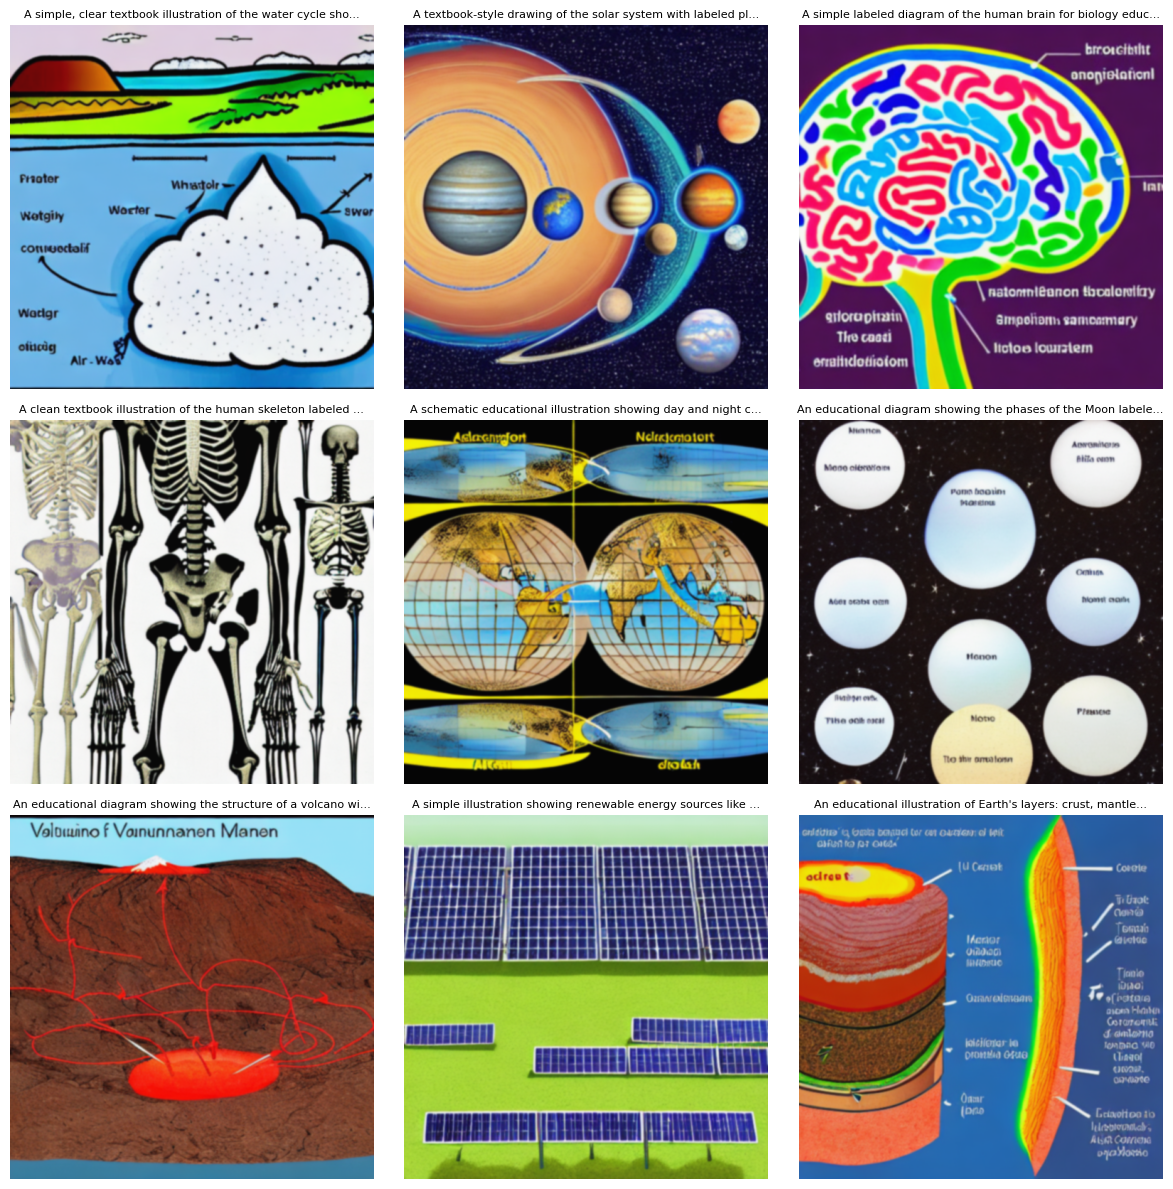

In [ ]:
# ---------------------------
# Sampling (reverse diffusion)
# ---------------------------
@torch.no_grad()
def generate_images(prompts, n_steps=T):
    unet.eval()
    txt_emb = encode_texts(prompts)
    imgs = torch.randn(len(prompts), 3, IMG_SIZE, IMG_SIZE).to(DEVICE)
    for i in reversed(range(1, n_steps)):
        t = torch.full((len(prompts),), i, device=DEVICE)
        pred_noise = unet(imgs, t.float()/T, txt_emb)
        alpha = alphas[i]; alpha_bar = alphas_cumprod[i]
        beta = betas[i]
        imgs = (1/torch.sqrt(alpha))*(imgs - (beta/torch.sqrt(1-alpha_bar))*pred_noise)
        if i>1:
            noise = torch.randn_like(imgs)
            imgs += torch.sqrt(beta)*noise
    imgs = torch.clamp((imgs+1)/2, 0, 1)
    return imgs

# ---------------------------
# Generate & visualize STEM diagrams
# ---------------------------

prompts_baseline = [
    "A simple, clear textbook illustration of the water cycle showing evaporation, condensation, and precipitation",
    "A textbook-style drawing of the solar system with labeled planets orbiting the sun",
    "A simple labeled diagram of the human brain for biology education",
    "A clean textbook illustration of the human skeleton labeled with major bones",
    "A schematic educational illustration showing day and night caused by Earth's rotation",
    "An educational diagram showing the phases of the Moon labeled in order",
    "An educational diagram showing the structure of a volcano with labeled magma chamber and crater",
    "A simple illustration showing renewable energy sources like solar panels and wind turbines",
    "An educational illustration of Earth's layers: crust, mantle, outer core, inner core",
]


# ---------------------------------------------------
# Visualize pseudo-baseline images
# ---------------------------------------------------
rows = (len(baseline_imgs) + 2) // 3  # auto fit rows
plt.figure(figsize=(12, rows * 4))
for i, img in enumerate(baseline_imgs):
    plt.subplot(rows, 3, i + 1)
    plt.imshow(img)
    plt.title(prompts_baseline[i][:60] + "...", fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()

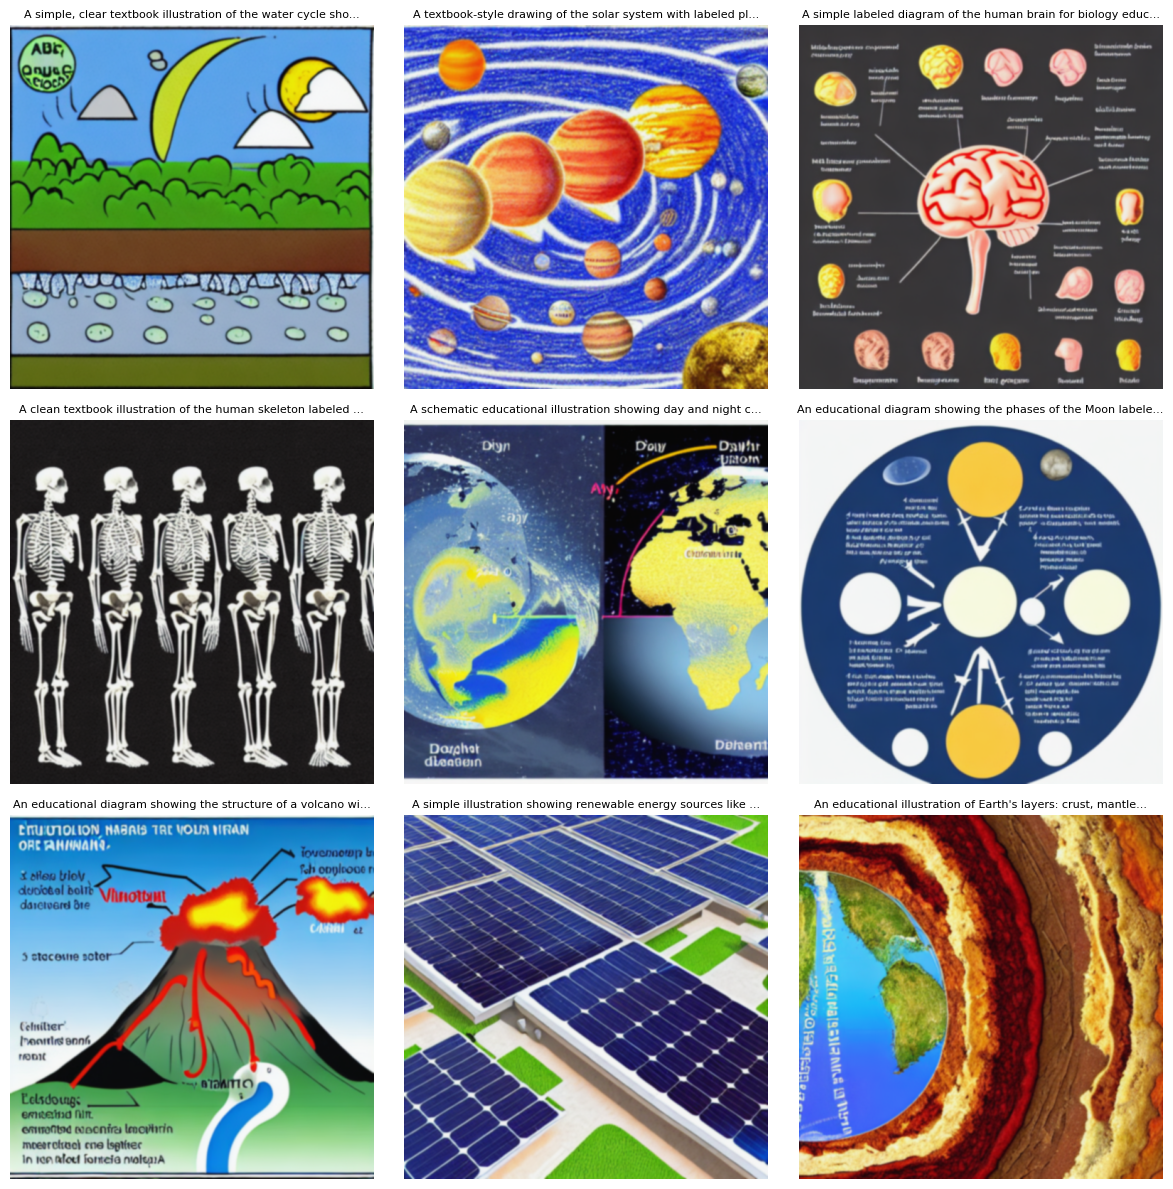

In [ ]:
# ---------------------------
# Sampling (reverse diffusion)
# ---------------------------
@torch.no_grad()
def generate_images(prompts, n_steps=T):
    unet.eval()
    txt_emb = encode_texts(prompts)
    imgs = torch.randn(len(prompts), 3, IMG_SIZE, IMG_SIZE).to(DEVICE)
    for i in reversed(range(1, n_steps)):
        t = torch.full((len(prompts),), i, device=DEVICE)
        pred_noise = unet(imgs, t.float()/T, txt_emb)
        alpha = alphas[i]; alpha_bar = alphas_cumprod[i]
        beta = betas[i]
        imgs = (1/torch.sqrt(alpha))*(imgs - (beta/torch.sqrt(1-alpha_bar))*pred_noise)
        if i>1:
            noise = torch.randn_like(imgs)
            imgs += torch.sqrt(beta)*noise
    imgs = torch.clamp((imgs+1)/2, 0, 1)
    return imgs

# ---------------------------
# Generate & visualize STEM diagrams
# ---------------------------

prompts_baseline = [
    "A simple, clear textbook illustration of the water cycle showing evaporation, condensation, and precipitation",
    "A textbook-style drawing of the solar system with labeled planets orbiting the sun",
    "A simple labeled diagram of the human brain for biology education",
    "A clean textbook illustration of the human skeleton labeled with major bones",
    "A schematic educational illustration showing day and night caused by Earth's rotation",
    "An educational diagram showing the phases of the Moon labeled in order",
    "An educational diagram showing the structure of a volcano with labeled magma chamber and crater",
    "A simple illustration showing renewable energy sources like solar panels and wind turbines",
    "An educational illustration of Earth's layers: crust, mantle, outer core, inner core",
]


# ---------------------------------------------------
# Visualize pseudo-baseline images
# ---------------------------------------------------
rows = (len(baseline_imgs) + 2) // 3  # auto fit rows
plt.figure(figsize=(12, rows * 4))
for i, img in enumerate(baseline_imgs):
    plt.subplot(rows, 3, i + 1)
    plt.imshow(img)
    plt.title(prompts_baseline[i][:60] + "...", fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:

# ---------------------------
# Evaluation Metrics
# ---------------------------
def evaluate_generated(model_imgs, ref_imgs, prompts):
    model_imgs = torch.clamp(model_imgs, 0, 1)
    ref_imgs = torch.clamp(ref_imgs, 0, 1)

    mse = F.mse_loss(model_imgs, ref_imgs).item()
    mae = F.l1_loss(model_imgs, ref_imgs).item()

    ssim_val = ssim(model_imgs[0].permute(1,2,0).cpu().numpy(),
                    ref_imgs[0].permute(1,2,0).cpu().numpy(),
                    channel_axis=-1, data_range=1.0)

    fid = FrechetInceptionDistance(normalize=True).to(DEVICE)
    fid.update((model_imgs*255).byte(), real=False)
    fid.update((ref_imgs*255).byte(), real=True)
    fid_val = fid.compute().item()

    emb1 = sbert.encode(prompts, convert_to_tensor=True, device=DEVICE)
    emb2 = sbert.encode(prompts, convert_to_tensor=True, device=DEVICE)
    cos_sim = util.cos_sim(emb1, emb2).mean().item()

    # Image entropy/diversity
    all_pixels = model_imgs.flatten().cpu().numpy()
    hist, _ = np.histogram(all_pixels, bins=256, range=(0,1), density=True)
    entropy = -np.sum(hist*np.log(hist+1e-12))

    return {"MSE":mse, "MAE":mae, "SSIM":ssim_val, "FID":fid_val, "Cosine":cos_sim, "Entropy":entropy}


In [ ]:
# Take a reference batch from validation set

val_batch = next(iter(val_loader))[0].to(DEVICE)
n = min(len(prompts), val_batch.size(0))
ref_imgs = val_batch[:n]
prompts_eval = prompts[:n]

metrics_baseline = evaluate_generated(baseline_imgs[:n], ref_imgs, prompts_eval)
print("Evaluation Metrics:", metrics_baseline)



Evaluation Metrics: {'MSE': 0.2433185875415802, 'MAE': 0.41189900040626526, 'SSIM': np.float32(0.046115506), 'FID': 427.6869812011719, 'Cosine': 0.4017396569252014, 'Entropy': np.float64(-37.576694303512404)}


In [ ]:

# ---------------------------------------------------
# Save model checkpoint (for backend use)
# ---------------------------------------------------
torch.save(unet.state_dict(), "diffusion_stem_v2.pt")
print("✅ Saved model as diffusion_stem_v2.pt")


✅ Saved model as diffusion_stem_v2.pt
